# Pre-Processing Weather Station Data

## Table of Contents
1. [Load in Data](#1-load-in-data)
- **Objective**: Load the dataset for pre-processing.  
- **Instructions**: I direct downloaded my specific weather stations data from NCEI, if you want to follow along, you can comment out how I load it in, and instead uncomment the code I left to download it from the internet. (The file is around ~600mb)
2. [Exploratory Data Analysis (EDA)](#2-exploratory-data-analysis-eda)
- **Objective**: Examine the weather station data to identify areas requiring pre-processing or feature engineering.
- **Steps**:
  1. `.transpose().describe()` to summarize key statistics.
  2. Analysis of minute selection for Hourly Data
  3. Visualizing Wind Direction
  4. Visualizing other Features
  5. Correlation Heatmap
3. [Feature Engineering and Pre-Processing](#3-feature-engineering-and-pre-processing)
- **Objective**: Prepare the data for a time series model by engineering and cleaning features.
- **Steps**:
  1. **Creating missing 52nd minute rows**:
     - Generate rows for the 52nd minute if missing and fill them with `NaN` values.
  2. **Cloud Data Pre-Processing**:
     - **Setting Base height to 0 for all clear sky entries**:
     - **Reasoning for cloud cover interpolation method and feature engineering**:
     - **Interpolating values for cloud cover**:
     - **Dimenstionality reduction for Cloud Cover and Base Height**:
     - **Interpolating values for cloud cover**:
  3. **Fixing Wind Direction and Wind Speed**:
  4. **Fixing other columns**:
4. [Frequency](#4-frequency)
- **Objective**: Ensure the model has access to the most relevant frequency features for accurate predictions.
- **Steps**:
  1. **Subselecting to only include 52nd minute row entries**:
     - Generate rows for the 52nd minute if missing and fill them with `NaN` values.
  2. **Determing frequency importance for different features**:

5. [Saving New Data File](#5-saving-new-data-file)
- **Objective**: Save the processed dataset for use in model and results file.

# 1-load-in-data
I am using hourly data from a single weather station in Kansas.

In [1]:
# Packages for this notebook
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Load in the dataset from the internet
# url = "https://www.ncei.noaa.gov/oa/global-historical-climatology-network/index.html#hourly/access/by-station/GHCNh_USW00013985_por.psv"
# df = pd.read_csv(url, delimiter='|')

# I downloaded the dataset directly
usc_station_path_2 = '/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/GHCNh_USW00013985_por.psv'
USW00013985 = pd.read_csv(usc_station_path_2, sep='|', low_memory=False)


/Users/evansweeney/Desktop/492_project_local/cmse492_project/tornado/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Columns I'll be using
useful_columns = [
    'Year', 'Month', 'Day', 'Hour', 'Minute', 'temperature', 'dew_point_temperature', 
    'wet_bulb_temperature', 'station_level_pressure', 'sea_level_pressure', 
    'wind_direction', 'wind_speed', 'wind_gust', 'relative_humidity', 'precipitation',
    'sky_cover_1', 'sky_cover_2', 'sky_cover_3', 'sky_cover_baseht_1', 'sky_cover_baseht_2', 'sky_cover_baseht_3',
    'visibility'
]
# Subsetting to only include 2011 to 2016
USW00013985 = USW00013985[(USW00013985['Year'] >= 2011) & (USW00013985['Year'] <= 2016)][useful_columns]
# Creating our Datetime column
USW00013985['Datetime'] = pd.to_datetime(USW00013985[['Year', 'Month', 'Day', 'Hour', 'Minute']])
# Dropping the columns we used to make the Datetime column
USW00013985.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
# Preference to make Datetime first column for now
USW00013985 = USW00013985[['Datetime'] + [col for col in USW00013985.columns if col != 'Datetime']]
print(USW00013985)

                  Datetime  temperature  dew_point_temperature  \
674454 2011-01-01 00:00:00        -13.3                  -19.4   
674455 2011-01-01 00:52:00        -15.0                  -20.0   
674456 2011-01-01 01:52:00        -14.4                  -19.4   
674457 2011-01-01 02:52:00        -14.4                  -20.0   
674458 2011-01-01 03:00:00        -14.4                  -20.0   
...                    ...          ...                    ...   
757039 2016-12-31 20:52:00         15.6                   -8.3   
757040 2016-12-31 21:00:00         15.6                   -8.3   
757041 2016-12-31 21:52:00          NaN                    NaN   
757042 2016-12-31 22:52:00          NaN                    NaN   
757043 2016-12-31 23:52:00          1.1                   -8.9   

        wet_bulb_temperature  station_level_pressure  sea_level_pressure  \
674454                 -14.5                   920.4              1016.0   
674455                 -15.9                   921.2   

# 2-exploratory-data-analysis-eda

### Transpose results
The statistics on my dataset so far look, there was just one thing I took note of:
* Wind direction is suppose to be 0 - 360 degrees, but the max value is 999, indicating we'll have to remove and interpolate some entries
* Feeding a model wind direction from 0 - 360 degrees won't work well, so I'll convert wind speed and wind direction into Wx and Wy columns.

In [3]:
USW00013985.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Datetime,82590,2014-01-08 08:05:25.997820672,2011-01-01 00:00:00,2012-07-09 23:54:00,2014-01-16 12:26:00,2015-07-04 14:58:00,2016-12-31 23:52:00,NaN
temperature,82532.0,12.479366,-26.1,3.0,13.3,21.7,43.3,11.978789
dew_point_temperature,82534.0,4.008844,-28.9,-3.9,3.9,13.0,23.0,9.971921
wet_bulb_temperature,82359.0,8.143024,-26.4,0.7,8.9,16.7,24.9,9.484977
station_level_pressure,82394.0,924.461579,897.9,920.5,924.6,928.7,954.7,6.574302
sea_level_pressure,69807.0,1015.184744,984.8,1009.8,1014.8,1020.3,1052.6,8.196101
wind_direction,79450.0,187.651479,10.0,130.0,180.0,260.0,999.0,106.518471
wind_speed,82376.0,5.74491,0.0,3.6,5.1,7.7,28.0,3.023931
wind_gust,16927.0,13.31679,0.0,11.3,12.9,14.9,30.9,3.21802
relative_humidity,82532.0,62.499964,3.0,44.0,65.0,83.0,100.0,23.38576


### Analysis of Minute Selection for Hourly Data

After analyzing the data, I identified two main minutes on the hour that tend to have the majority of entries:

- **52nd minute**  
- **00 minute**

Since my goal is to prepare evenly spaced, hourly data for a time series classification model, I need to choose a specific minute to standardize across the dataset. Based on the results:

1. The **52nd minute** had more entries than the 00 minute for most hours (2011–2016).
2. However, a few hours lacked entries for the 52nd minute.

To address these gaps, I will **interpolate missing values** for the 52nd minute. Later in this notebook, I’ll present my reasoning and methodology for performing this interpolation.


In [4]:
features = [
    'temperature', 'dew_point_temperature', 'wet_bulb_temperature', 'station_level_pressure', 
    'sea_level_pressure', 'wind_direction', 'wind_speed', 'wind_gust', 
    'relative_humidity', 'precipitation','sky_cover_1', 'sky_cover_2', 'sky_cover_3', 
    'sky_cover_baseht_1', 'sky_cover_baseht_2', 'sky_cover_baseht_3', 'visibility'
]

# length of all the rows
num_rows = len(USW00013985) 

# number of rows I should have
start_date = pd.Timestamp("2011-01-01 00:52:00")
end_date = pd.Timestamp("2016-12-31 23:52:00")
expected_hours = pd.date_range(start=start_date, end=end_date, freq='h').shape[0]

# After findnig that most entries are for either the 52nd or 00 minute, I want to compare them
# to see which minute on the hour I would want to use
entries_00 = USW00013985.loc[USW00013985['Datetime'].dt.minute == 0, features].notna().sum()
entries_52 = USW00013985.loc[USW00013985['Datetime'].dt.minute == 52, features].notna().sum()

# Print the results
print(f"Number of rows in the DataFrame: {num_rows}")
print(f"Rows I should have: {expected_hours}")
print("\nEntries for each feature at the 00 minte:")
print(entries_00)
print("\nEntries for each feature at the 52 minte:")
print(entries_52)

Number of rows in the DataFrame: 82590
Rows I should have: 52608

Entries for each feature at the 00 minte:
temperature               17693
dew_point_temperature     17695
wet_bulb_temperature      17579
station_level_pressure    17590
sea_level_pressure        17374
wind_direction            17115
wind_speed                17585
wind_gust                  1058
relative_humidity         17693
precipitation               107
sky_cover_1                5401
sky_cover_2                 113
sky_cover_3                  47
sky_cover_baseht_1          227
sky_cover_baseht_2           91
sky_cover_baseht_3           47
visibility                  239
dtype: int64

Entries for each feature at the 52 minte:
temperature               52534
dew_point_temperature     52534
wet_bulb_temperature      52491
station_level_pressure    52509
sea_level_pressure        52394
wind_direction            50506
wind_speed                52499
wind_gust                 12377
relative_humidity         52534
prec

### Visualizing Wind Direction

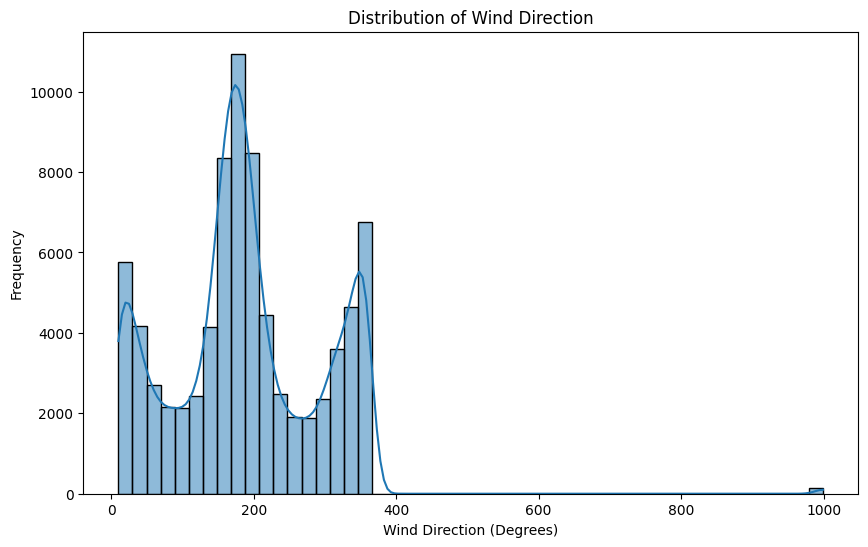

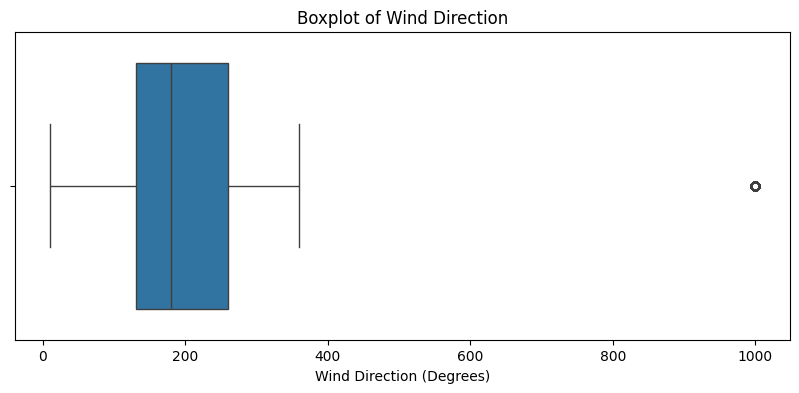

In [5]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(USW00013985['wind_direction'], bins=50, kde=True)
plt.title('Distribution of Wind Direction')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=USW00013985['wind_direction'])
plt.title('Boxplot of Wind Direction')
plt.xlabel('Wind Direction (Degrees)')
plt.show()

### Visualizing my other columns

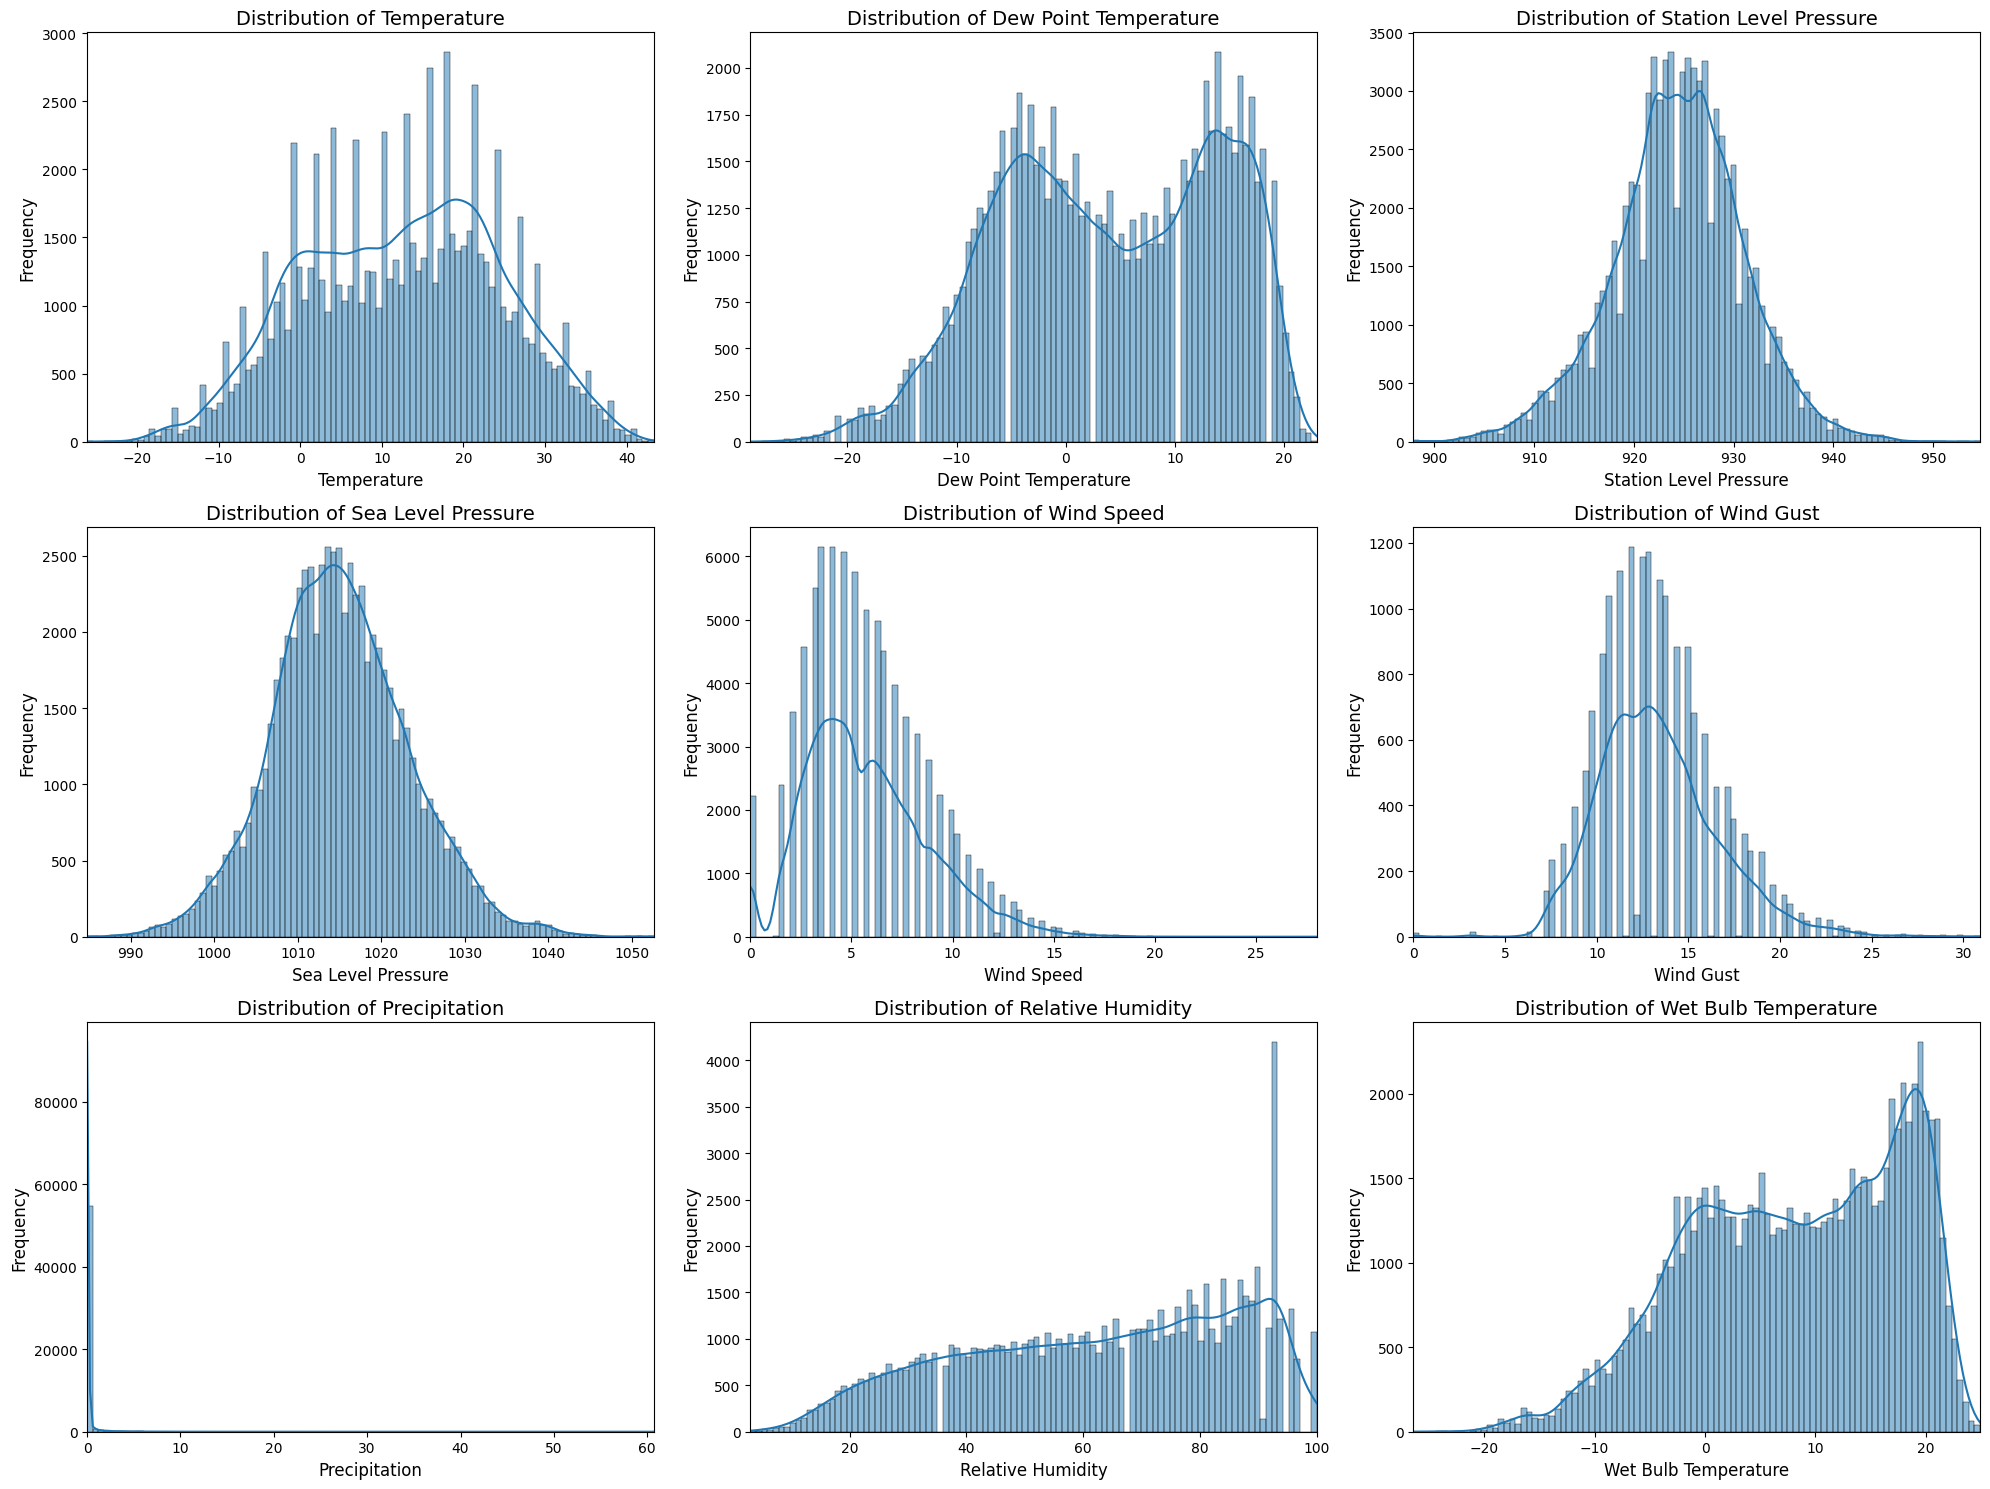

In [6]:
# features for plotting
columns_to_plot = [
    'temperature', 'dew_point_temperature', 'station_level_pressure', 'sea_level_pressure',
    'wind_speed', 'wind_gust', 'precipitation', 'relative_humidity', 'wet_bulb_temperature'
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten() 

# for loop to create a plot for each feature
for idx, col in enumerate(columns_to_plot):
    sns.histplot(data=USW00013985, x=col, bins=100, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}', fontsize=14)
    axes[idx].set_xlabel(col.replace("_", " ").title(), fontsize=12)
    axes[idx].set_ylabel('Frequency', fontsize=12)
    axes[idx].tick_params(axis='both', which='major', labelsize=10)
    # set so even outliers are visible
    axes[idx].set_xlim(USW00013985[col].min(), USW00013985[col].max())

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Correlation Matrix Heatmap for data

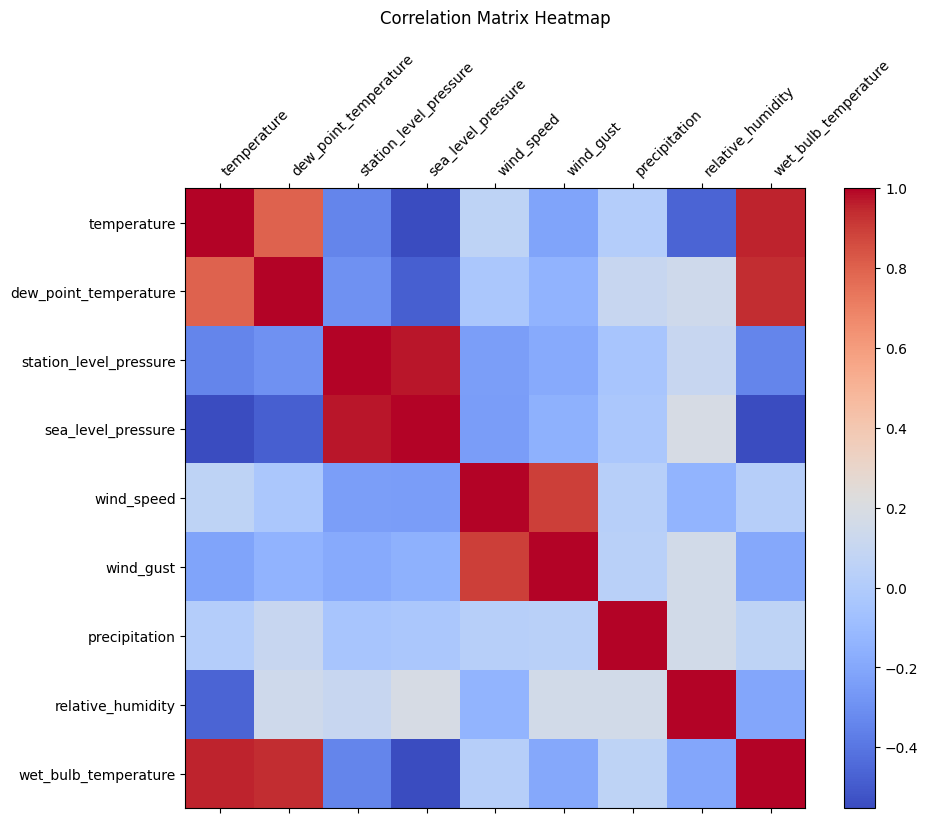

In [7]:
# computing and showing the correlation matrix
features = columns_to_plot
correlation_matrix = USW00013985[features].corr()

plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(features)), features, rotation=45, ha='left')
plt.yticks(range(len(features)), features)
plt.title("Correlation Matrix Heatmap", pad=20)
plt.show()

# 3-feature-engineering-and-pre-processing

### Creating missing 52nd minute rows

In [8]:
# Defining the start and end of my entire dataset
start_date = pd.Timestamp("2011-01-01 00:52:00")
end_date = pd.Timestamp("2016-12-31 23:52:00")

# Finding how many entries I want for the 52nd minute
expected_timestamps_52 = pd.date_range(start=start_date, end=end_date, freq='h')

# Finding how many entries I already have for the 52nd minute
actual_timestamps_52 = USW00013985.loc[USW00013985['Datetime'].dt.minute == 52, 'Datetime']
actual_52_len = USW00013985.loc[USW00013985['Datetime'].dt.minute == 52, 'Datetime'].shape[0]

# Variable to hold which entries I missing
missing_timestamps_52 = set(expected_timestamps_52) - set(actual_timestamps_52)

# Creating a DataFrame for the missing rows, filling new entries with NaNs
missing_rows = pd.DataFrame({
    'Datetime': list(missing_timestamps_52)
})
for feature in features:
    missing_rows[feature] = pd.NA

# Adding these new entries into my origianl dataset
USW00013985 = pd.concat([USW00013985, missing_rows], ignore_index=True)

# Making sure my dataset if sorted by time
USW00013985 = USW00013985.sort_values(by='Datetime').reset_index(drop=True)

# Calculate the actual and expected number of rows in the dataset for the 52nd minute
expected_rows_52 = pd.date_range(start=start_date, end=end_date, freq='h').shape[0]
actual_rows_52 = USW00013985.loc[USW00013985['Datetime'].dt.minute == 52].shape[0]

# Printing comparisons
print(f"Rows for the 52nd minute before any changes: {actual_52_len}")
print(f"Expected number of rows for the 52nd minute: {expected_rows_52}")
print(f"Added {len(missing_timestamps_52)} missing rows for the 52nd minute.")
print(f"Actual number of rows for the 52nd minute now: {actual_rows_52}")

Rows for the 52nd minute before any changes: 52552
Expected number of rows for the 52nd minute: 52608
Added 56 missing rows for the 52nd minute.
Actual number of rows for the 52nd minute now: 52608


/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_14713/2784452600.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  USW00013985 = pd.concat([USW00013985, missing_rows], ignore_index=True)


### Setting Base height to 0 for all clear sky entries

Since I can't pass NaN values to a model, I'm changing the base height column that corresponds to the first sky cover column to 0 for any clear sky entries.

In [9]:
USW00013985.loc[USW00013985['sky_cover_1'] == 'CLR:00', 'sky_cover_baseht_1'] = 0

# Making sure that works
print(USW00013985.loc[USW00013985['sky_cover_1'] == 'CLR:00', ['Datetime', 'sky_cover_1', 'sky_cover_baseht_1']].head(10))

             Datetime sky_cover_1  sky_cover_baseht_1
0 2011-01-01 00:00:00      CLR:00                 0.0
1 2011-01-01 00:52:00      CLR:00                 0.0
2 2011-01-01 01:52:00      CLR:00                 0.0
3 2011-01-01 02:52:00      CLR:00                 0.0
4 2011-01-01 03:00:00      CLR:00                 0.0
5 2011-01-01 03:52:00      CLR:00                 0.0
6 2011-01-01 04:52:00      CLR:00                 0.0
7 2011-01-01 05:52:00      CLR:00                 0.0
8 2011-01-01 06:00:00      CLR:00                 0.0
9 2011-01-01 06:52:00      CLR:00                 0.0


### Reasoning for cloud cover interpolation method and feature engineering

There are significant gaps of time without any sky cover entries for the first column.

In [10]:
USW00013985['Datetime'] = pd.to_datetime(USW00013985['Datetime'])
USW00013985 = USW00013985.sort_values(by='Datetime').reset_index(drop=True)

# Only concerned about 52nd minute entries, because that is our hourly data use
nan_entries = USW00013985[
    (USW00013985['Datetime'].dt.minute == 52) &
    (USW00013985['sky_cover_1'].isna())
]


random_nan_entries = nan_entries.sample(n=5, random_state=42)

    # selecting 10 rows around the random NaN entry
for idx in random_nan_entries.index:
    start_idx = max(0, idx - 5)  # preventing negatives
    end_idx = min(len(USW00013985), idx + 6)  # preventing out of bounds

    print(f"\nShowing rows {start_idx} to {end_idx - 1} around index {idx}:")
    display_df = USW00013985[['Datetime', 'sky_cover_1', 'sky_cover_baseht_1']].iloc[start_idx:end_idx]
    print(display_df.to_string(index=False))


Showing rows 45826 to 45836 around index 45831:
           Datetime sky_cover_1  sky_cover_baseht_1
2014-05-15 00:52:00      CLR:00                 0.0
2014-05-15 01:52:00      BKN:07              3353.0
2014-05-15 02:52:00      FEW:02              2896.0
2014-05-15 03:00:00         NaN                 NaN
2014-05-15 03:52:00         NaN                 NaN
2014-05-15 04:52:00         NaN                 NaN
2014-05-15 05:52:00      FEW:02              2896.0
2014-05-15 06:00:00         NaN                 NaN
2014-05-15 06:52:00      CLR:00                 0.0
2014-05-15 07:52:00      OVC:08              3048.0
2014-05-15 08:52:00      CLR:00                 0.0

Showing rows 32668 to 32678 around index 32673:
           Datetime sky_cover_1  sky_cover_baseht_1
2013-05-31 23:27:00         NaN                 NaN
2013-05-31 23:52:00         NaN                 NaN
2013-06-01 00:00:00         NaN                 NaN
2013-06-01 00:52:00         NaN                 NaN
2013-06-01 01:52:0

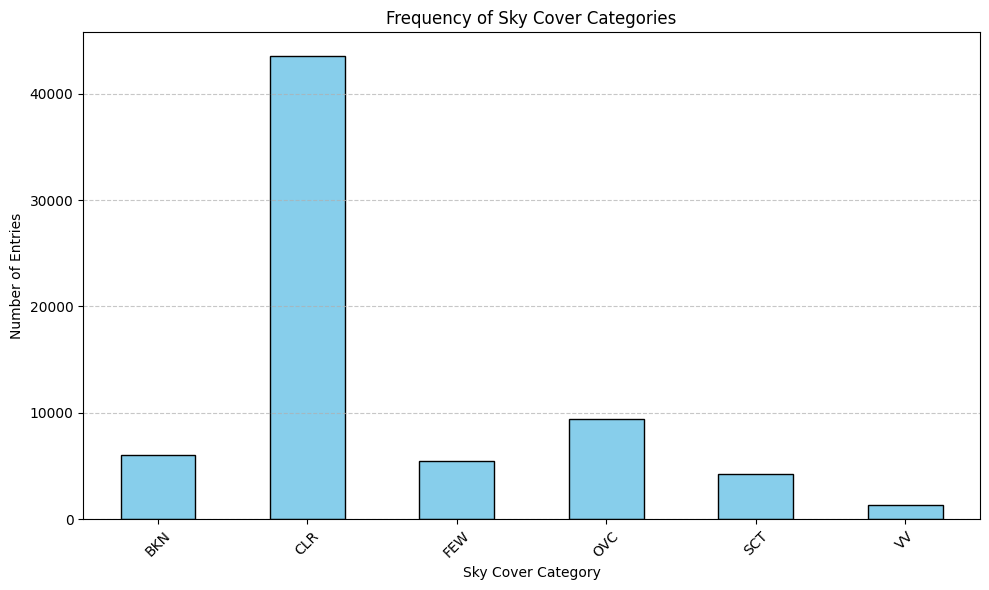

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the code numbers from 'sky_cover_1'
USW00013985['sky_cover_code'] = USW00013985['sky_cover_1'].str.split(':').str[-1]

# Map codes to descriptions
code_to_description = {
    '00': 'CLR',
    '01': 'FEW',
    '02': 'FEW',
    '03': 'SCT',
    '04': 'SCT',
    '05': 'BKN',
    '06': 'BKN',
    '07': 'BKN',
    '08': 'OVC',
    '09': 'VV',
    '10': 'X'    # The missing/ NaN values
}

USW00013985['sky_cover_description'] = USW00013985['sky_cover_code'].map(code_to_description)

# Count the occurrences of each category
category_counts = USW00013985['sky_cover_description'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Sky Cover Categories')
plt.xlabel('Sky Cover Category')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Interpolating values for cloud cover

I have 3 columns for sky cover and 3 columns for base height. The first column of sky cover should always have entries, and the other 2 columns are for if there are multiple layers of clouds present at any given time. This means that I will only interpolate 'sky_cover_1', becuase if the other layers don't have entries, there probably aren't muliple layers.

Since sky_cover_1 is as a class, where each class corresponds to a different amount of sky cover, and I can't interpolate based on these classes, I'll convert them to numeric values from 0 to 1. After I interpolate based on the numeric values, I'll convert back to the classes, then back again to the numeric. This is becuase, for all my rows that do have entries there is only 9 options it could take as a numeric value, and I want all of my data to be, similar.

In [12]:
# the sky cover code to the proportion of sky covered
code_to_fraction = {
    '00': 0.0,    
    '01': 0.125,  
    '02': 0.25,   
    '03': 0.375,  
    '04': 0.5,    
    '05': 0.625,  
    '06': 0.75,   
    '07': 0.875,  
    '08': 1.0,    
    '09': 1.0,    
    '10': np.nan 
}

def sky_cover_code_to_fraction(sky_cover_entry):
    if pd.isna(sky_cover_entry):
        return np.nan
    try:
        code_number = sky_cover_entry.split(':')[-1]
        fraction = code_to_fraction.get(code_number, np.nan)
        return fraction
    except Exception:
        return np.nan

fraction_to_code = {v: k for k, v in code_to_fraction.items() if not np.isnan(v)}
sorted_fractions = sorted(fraction_to_code.keys())

def fraction_to_sky_cover_code(fraction):
    if np.isnan(fraction):
        return np.nan
    closest_fraction = min(sorted_fractions, key=lambda x: abs(x - fraction))
    code_number = fraction_to_code[closest_fraction]
    code_to_description = {
        '00': 'CLR',
        '01': 'FEW',
        '02': 'FEW',
        '03': 'SCT',
        '04': 'SCT',
        '05': 'BKN',
        '06': 'BKN',
        '07': 'BKN',
        '08': 'OVC',
        '09': 'VV',
        '10': 'X'    # The missing/ NaN values
    }
    description = code_to_description.get(code_number, 'Unknown')
    return f"{description}:{code_number}"

def convert_sky_cover_columns_to_fraction(df, sky_cover_columns):
    for col in sky_cover_columns:
        df[col + '_fraction'] = df[col].apply(sky_cover_code_to_fraction)
    return df

def interpolate_sky_cover_fraction(df, fraction_column_name):
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    df_52 = df[df.index.minute == 52].copy()
    df_52[fraction_column_name] = df_52[fraction_column_name].interpolate(method='time')
    df.update(df_52)
    df.reset_index(inplace=True)
    return df

def convert_fraction_to_sky_cover_code(df, fraction_column_name, sky_cover_column_name):
    df[sky_cover_column_name] = df[fraction_column_name].apply(fraction_to_sky_cover_code)
    return df


USW00013985['Datetime'] = pd.to_datetime(USW00013985['Datetime'])
USW00013985 = USW00013985.sort_values(by='Datetime').reset_index(drop=True)

# Passing original 3 columns to sky cover to fraction function
sky_cover_columns = ['sky_cover_1', 'sky_cover_2', 'sky_cover_3']
USW00013985 = convert_sky_cover_columns_to_fraction(USW00013985, sky_cover_columns)

# Interpolating missing values, using time method, for the sky cover fraction
USW00013985 = interpolate_sky_cover_fraction(USW00013985, 'sky_cover_1_fraction')

# Converting back into codes to keep values similar
USW00013985 = convert_fraction_to_sky_cover_code(
    USW00013985, 'sky_cover_1_fraction', 'sky_cover_1_interpolated')

# Converting all back to fraction again
USW00013985['sky_cover_1_interpolated_fraction'] = USW00013985['sky_cover_1_interpolated'].apply(
    sky_cover_code_to_fraction)

# using this code again prevented errors
USW00013985['Datetime'] = pd.to_datetime(USW00013985['Datetime'])
USW00013985 = USW00013985.sort_values('Datetime').reset_index(drop=True)
USW00013985.set_index('Datetime', inplace=True)

# interpolating missing base height values
USW00013985['sky_cover_baseht_1'] = USW00013985['sky_cover_baseht_1'].interpolate(method='time')

# setting the interpolated CLR:00 base height entries to 0
USW00013985.loc[USW00013985['sky_cover_1_interpolated'] == 'CLR:00', 'sky_cover_baseht_1'] = 0

# resetting datetime index
USW00013985.reset_index(inplace=True)

# showing if everything worked (NaN values for non 52nd minute don't matter)
print(USW00013985[['Datetime', 'sky_cover_1', 'sky_cover_1_fraction',
                   'sky_cover_1_interpolated', 'sky_cover_1_interpolated_fraction', 'sky_cover_baseht_1']].iloc[45826:45836])


                 Datetime sky_cover_1  sky_cover_1_fraction  \
45826 2014-05-15 00:52:00      CLR:00                 0.000   
45827 2014-05-15 01:52:00      BKN:07                 0.875   
45828 2014-05-15 02:52:00      FEW:02                 0.250   
45829 2014-05-15 03:00:00         NaN                   NaN   
45830 2014-05-15 03:52:00         NaN                 0.250   
45831 2014-05-15 04:52:00         NaN                 0.250   
45832 2014-05-15 05:52:00      FEW:02                 0.250   
45833 2014-05-15 06:00:00         NaN                   NaN   
45834 2014-05-15 06:52:00      CLR:00                 0.000   
45835 2014-05-15 07:52:00      OVC:08                 1.000   

      sky_cover_1_interpolated  sky_cover_1_interpolated_fraction  \
45826                   CLR:00                              0.000   
45827                   BKN:07                              0.875   
45828                   FEW:02                              0.250   
45829                      NaN

### Dimenstionality reduction for Cloud Cover and Base Height

Since I have so many columns for my sky cover and cloud height, I'll be combining them into 2 columns. sky_cover will take the largest value of any of the layers, and sky_cover_baseht will take the average values of the multiple layers if present.

In [13]:
import pandas as pd
import numpy as np

# Assume your DataFrame is named USW00013985

# Step 1: Calculate the maximum sky cover fraction
# Create a new column 'sky_cover' which is the maximum of the three fractions
sky_cover_fraction_columns = [
    'sky_cover_1_interpolated_fraction',
    'sky_cover_2_fraction',
    'sky_cover_3_fraction'
]

USW00013985['sky_cover'] = USW00013985[sky_cover_fraction_columns].max(axis=1)

# Step 2: Calculate the average of the available base heights
# Create a list of base height columns
base_height_columns = [
    'sky_cover_baseht_1',
    'sky_cover_baseht_2',
    'sky_cover_baseht_3'
]

# Ensure the base height columns are numeric
for col in base_height_columns:
    USW00013985[col] = pd.to_numeric(USW00013985[col], errors='coerce')

# Calculate the average base height, ignoring NaN values
USW00013985['sky_cover_baseht'] = USW00013985[base_height_columns].mean(axis=1)

# making sure everything worked
print(USW00013985[['Datetime', 'sky_cover_1', 'sky_cover_1_interpolated_fraction', 'sky_cover_baseht_1', 'sky_cover', 'sky_cover_baseht']].iloc[45826:45836])

                 Datetime sky_cover_1  sky_cover_1_interpolated_fraction  \
45826 2014-05-15 00:52:00      CLR:00                              0.000   
45827 2014-05-15 01:52:00      BKN:07                              0.875   
45828 2014-05-15 02:52:00      FEW:02                              0.250   
45829 2014-05-15 03:00:00         NaN                                NaN   
45830 2014-05-15 03:52:00         NaN                              0.250   
45831 2014-05-15 04:52:00         NaN                              0.250   
45832 2014-05-15 05:52:00      FEW:02                              0.250   
45833 2014-05-15 06:00:00         NaN                                NaN   
45834 2014-05-15 06:52:00      CLR:00                              0.000   
45835 2014-05-15 07:52:00      OVC:08                              1.000   

       sky_cover_baseht_1  sky_cover  sky_cover_baseht  
45826            0.000000      0.000          0.000000  
45827         3353.000000      0.875       3353.0

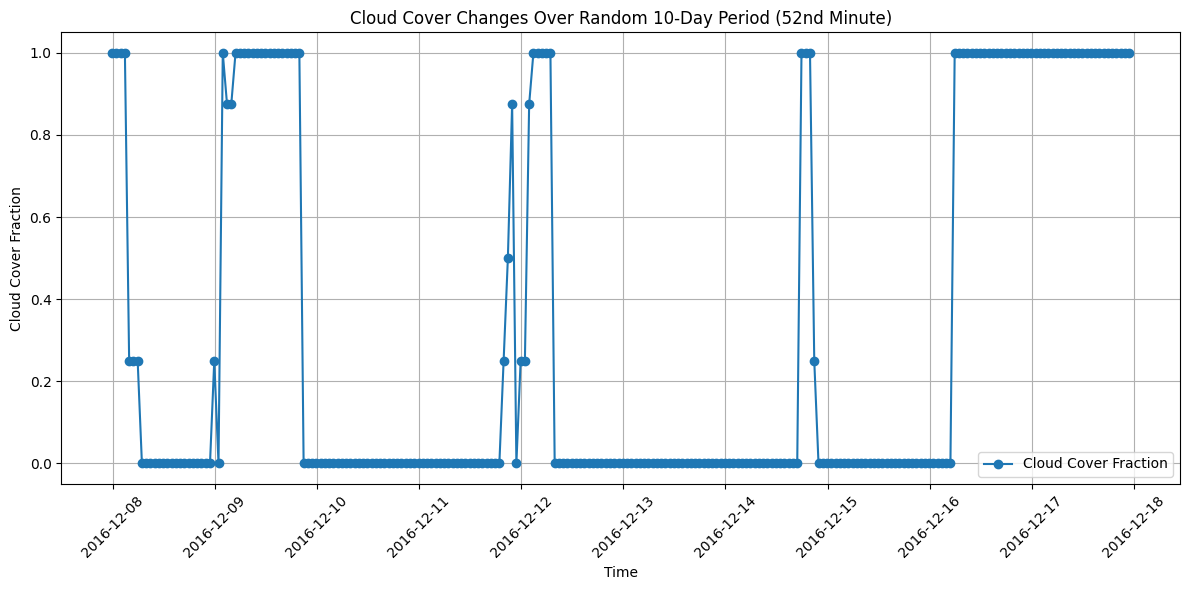

In [14]:
# Making sure to only take 52nd minute entries
data_52nd_minute = USW00013985[USW00013985['Datetime'].dt.minute == 52]

# Select a random 10-day subsection
start_idx = np.random.randint(0, len(data_52nd_minute) - 240)  # Approx 10 days of hourly data
end_idx = start_idx + 240  # Assuming ~24 entries per day (1 entry per hour)
random_10_day_section = data_52nd_minute.iloc[start_idx:end_idx]

# Plot the 10-day subsection
plt.figure(figsize=(12, 6))
plt.plot(random_10_day_section['Datetime'], random_10_day_section['sky_cover'], 
         label='Cloud Cover Fraction', linestyle='-', marker='o')
plt.title('Cloud Cover Changes Over Random 10-Day Period (52nd Minute)')
plt.xlabel('Time')
plt.ylabel('Cloud Cover Fraction')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Fixing Wind Direction and Wind Speed

In order to fix my Wind Direction and Wind Speed:
- set out of bounds (999) values to NaN
- interpolate missing values using time
- convert to Wx and Wy columns.

In [15]:
# Display unique values and count of missing values
print("Unique Wind Direction Values:", USW00013985['wind_direction'].unique())
print("Number of Missing Values:", USW00013985['wind_direction'].isnull().sum())

# Check for negative values or values exceeding 360
invalid_high = USW00013985[USW00013985['wind_direction'] > 360]
invalid_low = USW00013985[USW00013985['wind_direction'] < 0]
print(f"Number of wind_direction > 360: {invalid_high.shape[0]}")
print(f"Number of wind_direction < 0: {invalid_low.shape[0]}")

Unique Wind Direction Values: [290. 270. 250. 280. 300. 260. 240. 230. 170.  nan 130. 180. 190. 200.
 210. 220. 160. 310. 340. 360.  20.  10. 330. 140. 320. 350. 110. 150.
 120.  80. 100.  50.  60.  30.  70.  90.  40. 999.]
Number of Missing Values: 3196
Number of wind_direction > 360: 140
Number of wind_direction < 0: 0


In [16]:
# 0. Ensure 'Datetime' is in datetime format and set as index
USW00013985['Datetime'] = pd.to_datetime(USW00013985['Datetime'])
USW00013985.set_index('Datetime', inplace=True)

# 1. Replace invalid 'wind_direction' values with NaN
USW00013985['wind_direction'].replace(999, np.nan, inplace=True)

# 2. Interpolate 'wind_speed' using time-based interpolation
USW00013985['wind_speed'] = USW00013985['wind_speed'].interpolate(method='time')

# 3. Convert 'wind_direction' to radians
USW00013985['wind_direction_rad'] = np.deg2rad(USW00013985['wind_direction'])

# 4. Calculate sine and cosine components
USW00013985['wind_dir_sin'] = np.sin(USW00013985['wind_direction_rad'])
USW00013985['wind_dir_cos'] = np.cos(USW00013985['wind_direction_rad'])

# 5. Interpolate sine and cosine components using time-based interpolation
USW00013985['wind_dir_sin'] = USW00013985['wind_dir_sin'].interpolate(method='time')
USW00013985['wind_dir_cos'] = USW00013985['wind_dir_cos'].interpolate(method='time')

# 6. Reconstruct wind direction from interpolated components
USW00013985['wind_direction_rad'] = np.arctan2(
    USW00013985['wind_dir_sin'], USW00013985['wind_dir_cos']
)

# 7. Convert radians back to degrees
USW00013985['wind_direction'] = np.rad2deg(USW00013985['wind_direction_rad']) % 360

# 8. Compute wind x and y components
USW00013985['Wx'] = USW00013985['wind_speed'] * np.cos(USW00013985['wind_direction_rad'])
USW00013985['Wy'] = USW00013985['wind_speed'] * np.sin(USW00013985['wind_direction_rad'])

# 9. Drop intermediate columns
USW00013985.drop(['wind_dir_sin', 'wind_dir_cos', 'wind_direction_rad'], axis=1, inplace=True)

# 10. Reset index if you need 'Datetime' as a column again
USW00013985.reset_index(inplace=True)


/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_14713/2402320138.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  USW00013985['wind_direction'].replace(999, np.nan, inplace=True)


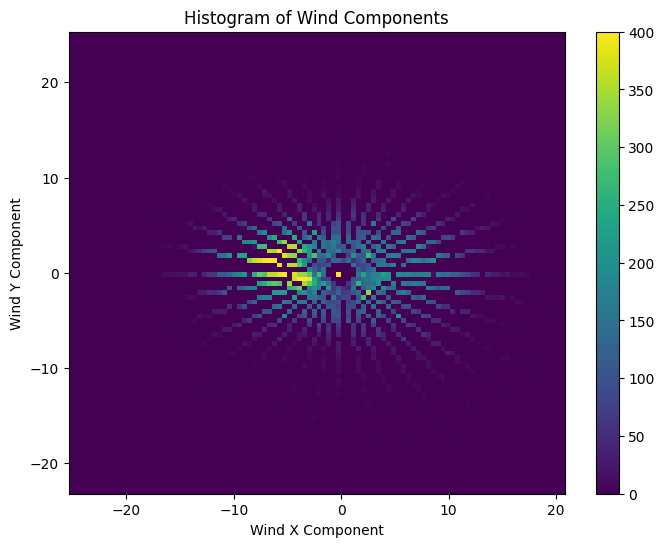

In [17]:
plt.figure(figsize=(8, 6))
plt.hist2d(USW00013985['Wx'], USW00013985['Wy'], bins=(100, 100), vmax=400)
plt.colorbar()
plt.xlabel('Wind X Component')
plt.ylabel('Wind Y Component')
plt.title('Histogram of Wind Components')
plt.show()

In [18]:
print("missing values for Wx", USW00013985['Wx'].isnull().sum())
print("missing values for Wx", USW00013985['Wy'].isnull().sum())

missing values for Wx 0
missing values for Wx 0


### Fixing other columns

Steps for fixing my other columns:
- Finding number of missing entries
- Interpolate or fill missing values

In [19]:
# 1. Print the shape of the DataFrame
df_shape = USW00013985.shape
print(f"DataFrame Shape: {df_shape[0]} rows, {df_shape[1]} columns\n")

# 2. Define the list of columns to check for missing entries
columns_to_check = [
    'temperature',
    'dew_point_temperature',
    'station_level_pressure',
    'sea_level_pressure',
    'wind_direction',
    'wind_speed',
    'wind_gust',
    'precipitation',
    'relative_humidity',
    'wet_bulb_temperature',
    'visibility'
]

# Verify that all specified columns exist in the DataFrame
missing_columns = [col for col in columns_to_check if col not in USW00013985.columns]
if missing_columns:
    print("Warning: The following columns are not in the DataFrame and will be skipped:")
    for col in missing_columns:
        print(f" - {col}")
    # Remove missing columns from the list to prevent errors
    columns_to_check = [col for col in columns_to_check if col in USW00013985.columns]

# 3. Calculate the number of missing entries for each specified column
missing_counts = USW00013985[columns_to_check].isnull().sum()

# 4. Print the missing counts in a readable format
print("Missing Entries per Column:")
for column, count in missing_counts.items():
    print(f" - {column}: {count} missing entries")



DataFrame Shape: 82646 rows, 29 columns

Missing Entries per Column:
 - temperature: 114 missing entries
 - dew_point_temperature: 112 missing entries
 - station_level_pressure: 252 missing entries
 - sea_level_pressure: 12839 missing entries
 - wind_direction: 0 missing entries
 - wind_speed: 0 missing entries
 - wind_gust: 65719 missing entries
 - precipitation: 25782 missing entries
 - relative_humidity: 114 missing entries
 - wet_bulb_temperature: 287 missing entries
 - visibility: 17615 missing entries


In [20]:
USW00013985['Datetime'] = pd.to_datetime(USW00013985['Datetime'])
USW00013985.set_index('Datetime', inplace=True)

variables_to_interpolate = ['temperature', 'dew_point_temperature', 'station_level_pressure', 
                            'sea_level_pressure', 'relative_humidity', 'wet_bulb_temperature']

for var in variables_to_interpolate:
    USW00013985[var] = USW00013985[var].interpolate(method='time')

USW00013985['wind_gust'].fillna(0, inplace=True)
USW00013985['precipitation'].fillna(0, inplace=True)
USW00013985['visibility'].fillna(16.093, inplace=True) 

print(USW00013985.isnull().sum())

temperature                              0
dew_point_temperature                    0
wet_bulb_temperature                     0
station_level_pressure                   0
sea_level_pressure                       0
wind_direction                           0
wind_speed                               0
wind_gust                                0
relative_humidity                        0
precipitation                            0
sky_cover_1                          12492
sky_cover_2                          73422
sky_cover_3                          79160
sky_cover_baseht_1                       0
sky_cover_baseht_2                   73445
sky_cover_baseht_3                   79160
visibility                               0
sky_cover_code                       12492
sky_cover_description                12492
sky_cover_1_fraction                 12356
sky_cover_2_fraction                 73422
sky_cover_3_fraction                 79160
sky_cover_1_interpolated             12356
sky_cover_1

/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_14713/2430018432.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  USW00013985['wind_gust'].fillna(0, inplace=True)
/var/folders/zb/18r7m2xd6rsfnqyxtl07h71w0000gn/T/ipykernel_14713/2430018432.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

# 4-frequency

### Subselecting to only include 52nd minute row entries

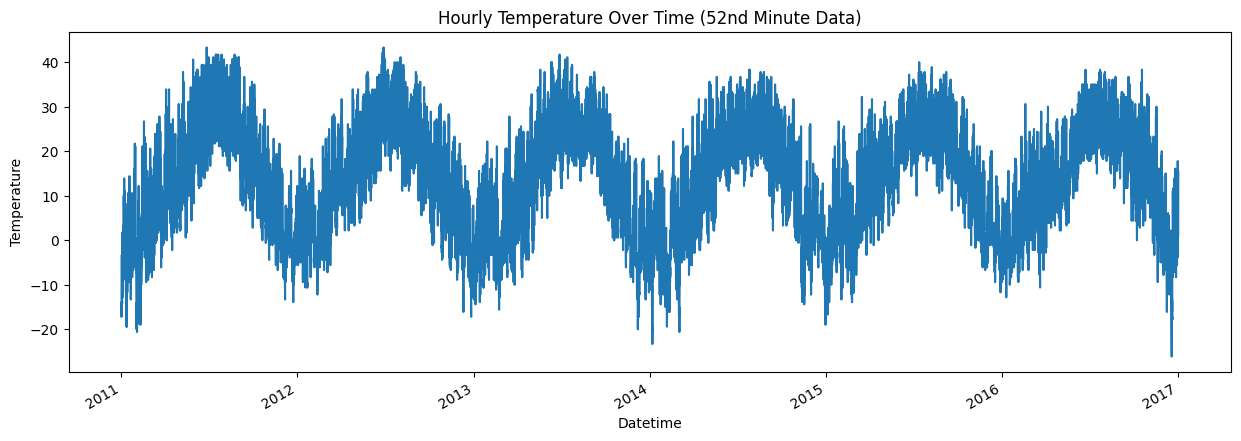

check for missing entries:
temperature               0
dew_point_temperature     0
wet_bulb_temperature      0
station_level_pressure    0
sea_level_pressure        0
wind_gust                 0
relative_humidity         0
precipitation             0
visibility                0
sky_cover                 0
sky_cover_baseht          0
Wx                        0
Wy                        0
dtype: int64
no missing rows is 52608: 52608


In [21]:
USW00013985.reset_index(inplace=True)
USW00013985['Datetime'] = pd.to_datetime(USW00013985['Datetime'])
USW00013985.set_index('Datetime', inplace=True)

# only 52nd minute entries
USW00013985_52 = USW00013985[USW00013985.index.minute == 52]

# start and end of my data
min_datetime = USW00013985_52.index.min().floor('h')
max_datetime = USW00013985_52.index.max().ceil('h')

# hourly data range for 52nd minute
hourly_index = pd.date_range(start=min_datetime, end=max_datetime, freq='h') + pd.Timedelta(minutes=52)

# reindexing
USW00013985_hourly = USW00013985_52.reindex(hourly_index)

# Plotting temperature column based on new subselection
plt.figure(figsize=(15, 5))
USW00013985_hourly['temperature'].plot()
plt.title('Hourly Temperature Over Time (52nd Minute Data)')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.show()

# When taking the new subselection for 52nd minute, an extra row was added to the end, so I removed it
USW00013985_hourly = USW00013985_hourly.iloc[:-1]

# Dropping the other columns in my dataset I don't need anymore
USW00013985_hourly = USW00013985_hourly.drop(columns=['sky_cover_1', 'sky_cover_2', 'sky_cover_3', 'sky_cover_baseht_1', 'sky_cover_baseht_2', 
                                                      'sky_cover_baseht_3', 'sky_cover_code', 'sky_cover_description', 'sky_cover_1_fraction', 
                                                      'sky_cover_2_fraction', 'sky_cover_3_fraction', 'sky_cover_1_interpolated', 'sky_cover_1_interpolated_fraction',
                                                      'wind_direction', 'wind_speed'])

# Double checking for missing entries
print("check for missing entries:\n" +  str(USW00013985_hourly.isnull().sum()))

# Entries match shape I need
print("no missing rows is 52608:", USW00013985_hourly.shape[0])

In [22]:
# converting datetime to seconds for frequency analysis
timestamp_s = USW00013985_hourly.index.map(pd.Timestamp.timestamp)
print(timestamp_s)

Index([1293843120.0, 1293846720.0, 1293850320.0, 1293853920.0, 1293857520.0,
       1293861120.0, 1293864720.0, 1293868320.0, 1293871920.0, 1293875520.0,
       ...
       1483195920.0, 1483199520.0, 1483203120.0, 1483206720.0, 1483210320.0,
       1483213920.0, 1483217520.0, 1483221120.0, 1483224720.0, 1483228320.0],
      dtype='float64', length=52608)


In [23]:
# Number of seconds in a day and a year
day = 24 * 60 * 60  # Seconds in a day
year = 365.2425 * day  # Average seconds in a year (accounting for leap years)

# Add time-based features to the DataFrame
USW00013985_hourly['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
USW00013985_hourly['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
USW00013985_hourly['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
USW00013985_hourly['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
print(USW00013985_hourly[['Day sin', 'Day cos', 'Year sin', 'Year cos']].head())
print(USW00013985_hourly[['Day sin', 'Day cos', 'Year sin', 'Year cos']].tail())

                      Day sin   Day cos  Year sin  Year cos
2011-01-01 00:52:00  0.224951  0.974370  0.001610  0.999999
2011-01-01 01:52:00  0.469472  0.882948  0.002327  0.999997
2011-01-01 02:52:00  0.681998  0.731354  0.003044  0.999995
2011-01-01 03:52:00  0.848048  0.529919  0.003761  0.999993
2011-01-01 04:52:00  0.956305  0.292372  0.004477  0.999990
                      Day sin   Day cos  Year sin  Year cos
2016-12-31 19:52:00 -0.882948  0.469472  0.007402  0.999973
2016-12-31 20:52:00 -0.731354  0.681998  0.008119  0.999967
2016-12-31 21:52:00 -0.529919  0.848048  0.008835  0.999961
2016-12-31 22:52:00 -0.292372  0.956305  0.009552  0.999954
2016-12-31 23:52:00 -0.034899  0.999391  0.010269  0.999947


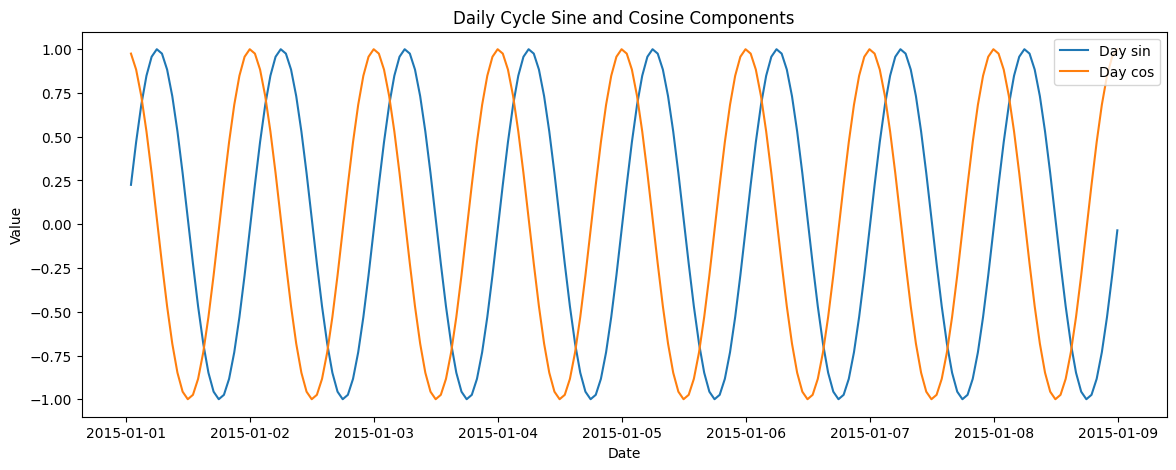

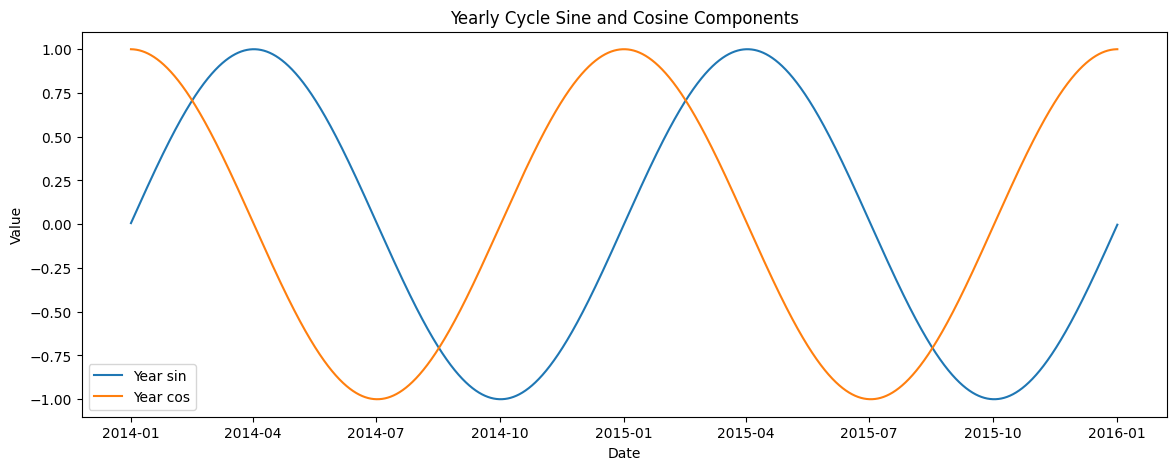

In [24]:
# day sin and cos over a random week
subset_day = USW00013985_hourly.loc['2015-01-01' : '2015-01-08']

plt.figure(figsize=(14, 5))
plt.plot(subset_day.index, subset_day['Day sin'], label='Day sin')
plt.plot(subset_day.index, subset_day['Day cos'], label='Day cos')
plt.title('Daily Cycle Sine and Cosine Components')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# over a random year
subset_year = USW00013985_hourly.loc['2014-01-01' : '2015-12-31']

plt.figure(figsize=(14, 5))
plt.plot(subset_year.index, subset_year['Year sin'], label='Year sin')
plt.plot(subset_year.index, subset_year['Year cos'], label='Year cos')
plt.title('Yearly Cycle Sine and Cosine Components')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

### Determing frequency importance for different features

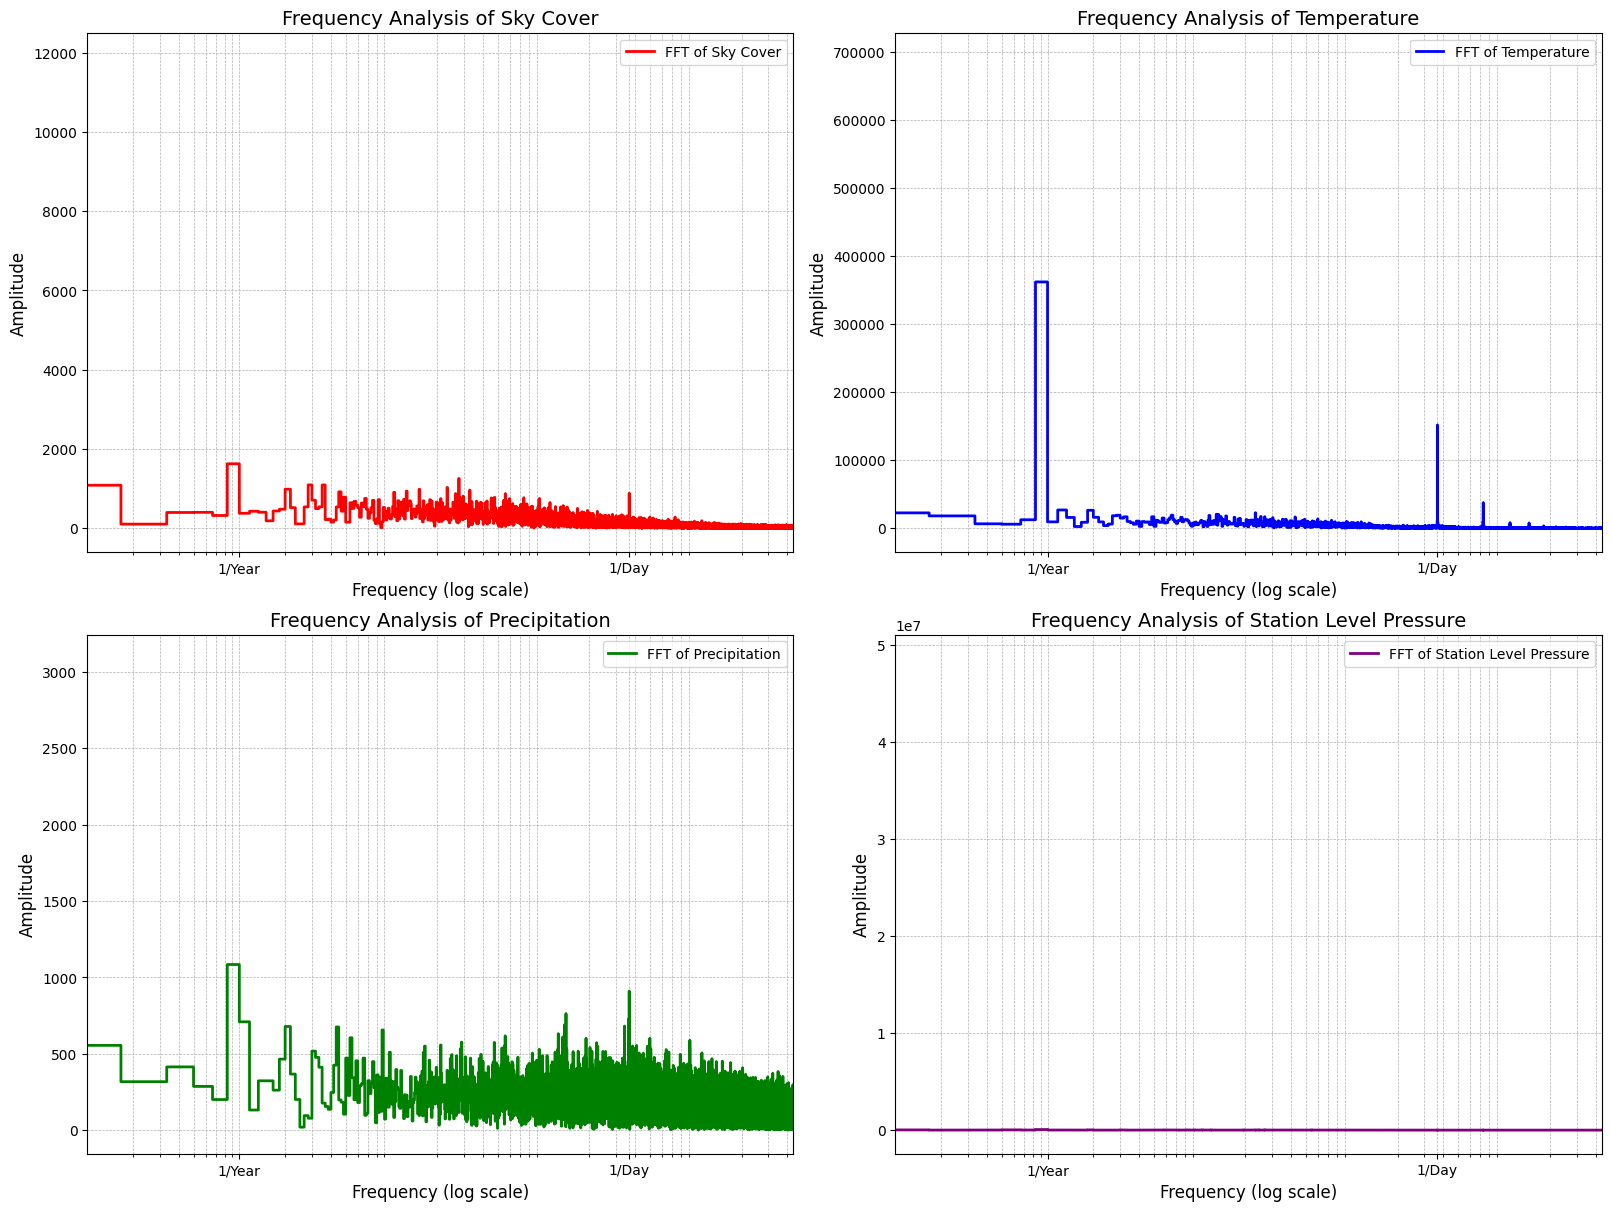

In [25]:
# extracting data and dropping NaNs
skyCover = USW00013985_hourly['sky_cover'].dropna()
temperature = USW00013985_hourly['temperature'].dropna()
precipitation = USW00013985_hourly['precipitation'].dropna()
station_pressure = USW00013985_hourly['station_level_pressure'].dropna()

# FFT for sky cover
fft_skyCover = tf.signal.rfft(skyCover)
n_samples_skyCover = len(skyCover)
hours_per_year = 24 * 365.5
years_per_dataset_skyCover = n_samples_skyCover / hours_per_year
f_per_dataset_skyCover = np.arange(0, len(fft_skyCover))
f_per_year_skyCover = f_per_dataset_skyCover / years_per_dataset_skyCover

# FFT for temperature
fft_temperature = tf.signal.rfft(temperature)
n_samples_temperature = len(temperature)
years_per_dataset_temperature = n_samples_temperature / hours_per_year
f_per_dataset_temperature = np.arange(0, len(fft_temperature))
f_per_year_temperature = f_per_dataset_temperature / years_per_dataset_temperature

# FFT for precipitation
fft_precipitation = tf.signal.rfft(precipitation)
n_samples_precipitation = len(precipitation)
years_per_dataset_precipitation = n_samples_precipitation / hours_per_year
f_per_dataset_precipitation = np.arange(0, len(fft_precipitation))
f_per_year_precipitation = f_per_dataset_precipitation / years_per_dataset_precipitation

# FFT for station level pressure
fft_station_pressure = tf.signal.rfft(station_pressure)
n_samples_station_pressure = len(station_pressure)
years_per_dataset_station_pressure = n_samples_station_pressure / hours_per_year
f_per_dataset_station_pressure = np.arange(0, len(fft_station_pressure))
f_per_year_station_pressure = f_per_dataset_station_pressure / years_per_dataset_station_pressure

# grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# Plot Sky Cover FFT
axes[0, 0].step(f_per_year_skyCover, np.abs(fft_skyCover), color='red', linewidth=2, label='FFT of Sky Cover')
axes[0, 0].set_xscale('log')
axes[0, 0].set_xlim([0.1, max(f_per_year_skyCover)])
axes[0, 0].set_xticks([1, 365.2524])
axes[0, 0].set_xticklabels(['1/Year', '1/Day'])
axes[0, 0].set_xlabel('Frequency (log scale)', fontsize=12)
axes[0, 0].set_ylabel('Amplitude', fontsize=12)
axes[0, 0].set_title('Frequency Analysis of Sky Cover', fontsize=14)
axes[0, 0].grid(which='both', linestyle='--', linewidth=0.5)
axes[0, 0].legend(fontsize=10)

# Plot Temperature FFT
axes[0, 1].step(f_per_year_temperature, np.abs(fft_temperature), color='blue', linewidth=2, label='FFT of Temperature')
axes[0, 1].set_xscale('log')
axes[0, 1].set_xlim([0.1, max(f_per_year_temperature)])
axes[0, 1].set_xticks([1, 365.2524])
axes[0, 1].set_xticklabels(['1/Year', '1/Day'])
axes[0, 1].set_xlabel('Frequency (log scale)', fontsize=12)
axes[0, 1].set_ylabel('Amplitude', fontsize=12)
axes[0, 1].set_title('Frequency Analysis of Temperature', fontsize=14)
axes[0, 1].grid(which='both', linestyle='--', linewidth=0.5)
axes[0, 1].legend(fontsize=10)

# Plot Precipitation FFT
axes[1, 0].step(f_per_year_precipitation, np.abs(fft_precipitation), color='green', linewidth=2, label='FFT of Precipitation')
axes[1, 0].set_xscale('log')
axes[1, 0].set_xlim([0.1, max(f_per_year_precipitation)])
axes[1, 0].set_xticks([1, 365.2524])
axes[1, 0].set_xticklabels(['1/Year', '1/Day'])
axes[1, 0].set_xlabel('Frequency (log scale)', fontsize=12)
axes[1, 0].set_ylabel('Amplitude', fontsize=12)
axes[1, 0].set_title('Frequency Analysis of Precipitation', fontsize=14)
axes[1, 0].grid(which='both', linestyle='--', linewidth=0.5)
axes[1, 0].legend(fontsize=10)

# Plot Station Level Pressure FFT
axes[1, 1].step(f_per_year_station_pressure, np.abs(fft_station_pressure), color='purple', linewidth=2, label='FFT of Station Level Pressure')
axes[1, 1].set_xscale('log')
axes[1, 1].set_xlim([0.1, max(f_per_year_station_pressure)])
axes[1, 1].set_xticks([1, 365.2524])
axes[1, 1].set_xticklabels(['1/Year', '1/Day'])
axes[1, 1].set_xlabel('Frequency (log scale)', fontsize=12)
axes[1, 1].set_ylabel('Amplitude', fontsize=12)
axes[1, 1].set_title('Frequency Analysis of Station Level Pressure', fontsize=14)
axes[1, 1].grid(which='both', linestyle='--', linewidth=0.5)
axes[1, 1].legend(fontsize=10)

# Show all plots
plt.show()


# 5-saving-new-data-file

In [26]:
# Double checking to make sure everything is good
print("check for missing entries:\n" +  str(USW00013985_hourly.isnull().sum()))
print("no missing rows is 52608:", USW00013985_hourly.shape[0])

check for missing entries:
temperature               0
dew_point_temperature     0
wet_bulb_temperature      0
station_level_pressure    0
sea_level_pressure        0
wind_gust                 0
relative_humidity         0
precipitation             0
visibility                0
sky_cover                 0
sky_cover_baseht          0
Wx                        0
Wy                        0
Day sin                   0
Day cos                   0
Year sin                  0
Year cos                  0
dtype: int64
no missing rows is 52608: 52608


In [27]:
file_path = '/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/KansasStationProcessed.csv'
USW00013985_hourly.to_csv(file_path)